In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unswnb15/UNSW_NB15_testing-set.parquet
/kaggle/input/unswnb15/UNSW_NB15_training-set.parquet


# UNSW-NB15 as a binary classification problem: 
In this notebook, I use the XGBoost model to classify the UNSW-NB15. The classification problem is treated as one binary problem, collapsing all available attack classes of the dataset. This is done to avoid over-estimating performance on the classes with few 'positive' (malicious) samples. Other versions may opt for analysis on the available attacks (or atk classes). 

## Stages
- an unoptimized XGBoost with sane hyperparam choices
- hyperparameter search per attack class
- re-train XGBoost with optimized hyperparameters and use early stopping with an unseen validation set
- unoptimized XGBoost trained with the full training set (no validation split off)
- thresholded XGBoost ([basis](https://www.kaggle.com/dhoogla/nsl-kdd-02-xgb-binary-0-971-auroc)) 

## Methodological choices
UNSW-NB15 has designated splits for training and testing. Unfortunately, since no validation set is provided, 15% of the training set will be kept apart until stage 3 to act as the validation set to be used during early stopping.

## Conclusion
There does seem to be room for improvement. Parameter optimization did not help with classification performance, instead a tiny decrease was observed. The use of early stopping in a potentially much larger (10x) XGBoost model with optimized parameters did not help either. **There is definitely overfitting going on.**

One effective step to get a minor increase in auroc was using the original train and test sets in **stage 4**, without splitting off a validation set. That model reached .9216 AUROC over the previous best .9213. 

You can get an AUROC of .985 if you pick a better threshold (**stage 6**), rather than the standard 0.5, but in this notebook, the stability of the chosen threshold is not tested, therefore, there is no telling if it would remain a positive modification if you ran this model in production.

In [4]:
import warnings
warnings.simplefilter(action='once', category=FutureWarning)

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from statistics import harmonic_mean
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [6]:
df_train = pd.read_parquet('/kaggle/input/unswnb15/UNSW_NB15_training-set.parquet')
df_test = pd.read_parquet('/kaggle/input/unswnb15/UNSW_NB15_testing-set.parquet')
df_train.shape, df_test.shape

((175341, 36), (82332, 36))

In [7]:
dep = 'label'

In [8]:
cats = list(df_train.select_dtypes(include='category').columns.values)
cats

['proto', 'service', 'state', 'attack_cat']

In [9]:
def train_test_category_union(feature):
    print(feature)
    tcl = len(df_train[feature].cat.categories)
    tcll = len(df_train[feature].cat.categories)
    feature_cat_union = df_train[feature].cat.categories.union(df_test[feature].cat.categories)    
    df_train[feature] = df_train[feature].cat.set_categories(feature_cat_union)
    df_test[feature] = df_test[feature].cat.set_categories(feature_cat_union)
    print(f"Added {len(df_train[feature].cat.categories)-tcl} for missing categories to training set")
    print(f"Added {len(df_test[feature].cat.categories)-tcll} for missing categories to testing set")

In [10]:
for f in cats:
    train_test_category_union(f)

proto
Added 0 for missing categories to training set
Added 0 for missing categories to testing set
service
Added 0 for missing categories to training set
Added 0 for missing categories to testing set
state
Added 2 for missing categories to training set
Added 2 for missing categories to testing set
attack_cat
Added 0 for missing categories to training set
Added 0 for missing categories to testing set


In [11]:
df_train[cats] = df_train[cats].apply(lambda x: x.cat.codes)
df_test[cats] = df_test[cats].apply(lambda x: x.cat.codes)

In [12]:
df_val = df_train.sample(frac=0.15,
                         replace=False,
                         weights=1./df_train.groupby('label')['label'].transform('count')).copy(deep=True)
df_train.drop(index=df_val.index, inplace=True)
df_train.shape, df_val.shape

((149040, 36), (26301, 36))

In [13]:
df_train.drop(columns=['attack_cat'], inplace=True)
df_val.drop(columns=['attack_cat'], inplace=True)
df_test.drop(columns=['attack_cat'], inplace=True)

In [14]:
df_train.label.value_counts(), df_val.label.value_counts()

(1    105753
 0     43287
 Name: label, dtype: int64,
 1    13588
 0    12713
 Name: label, dtype: int64)

In [15]:
df_train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'label'],
      dtype='object')

In [16]:
def xs_y(df_, targ):    
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [17]:
X_train, y_train = xs_y(df_train, dep)
X_val, y_val = xs_y(df_val, dep)
X_test, y_test = xs_y(df_test, dep)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((149040, 34), (149040,), (26301, 34), (26301,), (82332, 34), (82332,))

# Stage 1: XGBoost, sane defaults, no hyperparam optimization

In [18]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier
import pandas as pd

# Modify XGBClassifier to use CPU
xgb_noopt = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    max_depth=8,
    booster='gbtree',
    tree_method='hist',  # Change to 'hist' for CPU
    subsample=0.5,
    colsample_bytree=0.5,
    importance_type='gain',
    objective='binary:logistic',
    eval_metric='logloss',
    predictor='auto'  # Optional, can remove or set to 'auto'
)

# Fit the model on training data
xgb_noopt.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_noopt.predict(X_test)

# Calculate accuracy
accuracy = round(accuracy_score(y_true=y_test, y_pred=xgb_preds), 4)

# Update DataFrame with all metrics including accuracy
noopt_df = pd.DataFrame(data=[[
    'unsw-nb15-binary',
    'xgb-no-opt',
    X_train.shape,
    X_val.shape,
    X_test.shape,
    round(roc_auc_score(y_true=y_test, y_score=xgb_preds), 4),
    round(precision_score(y_true=y_test, y_pred=xgb_preds), 4),
    round(recall_score(y_true=y_test, y_pred=xgb_preds), 4),
    round(f1_score(y_true=y_test, y_pred=xgb_preds), 4),
    accuracy  # Adding accuracy to the DataFrame
]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1', 'Accuracy'])

# Display the DataFrame
print(noopt_df)

             AtkCls       model    TrainShape     ValShape    TestShape  \
0  unsw-nb15-binary  xgb-no-opt  (149040, 34)  (26301, 34)  (82332, 34)   

    Auroc  Precision  Recall      F1  Accuracy  
0  0.8508     0.8143  0.9736  0.8869    0.8632  


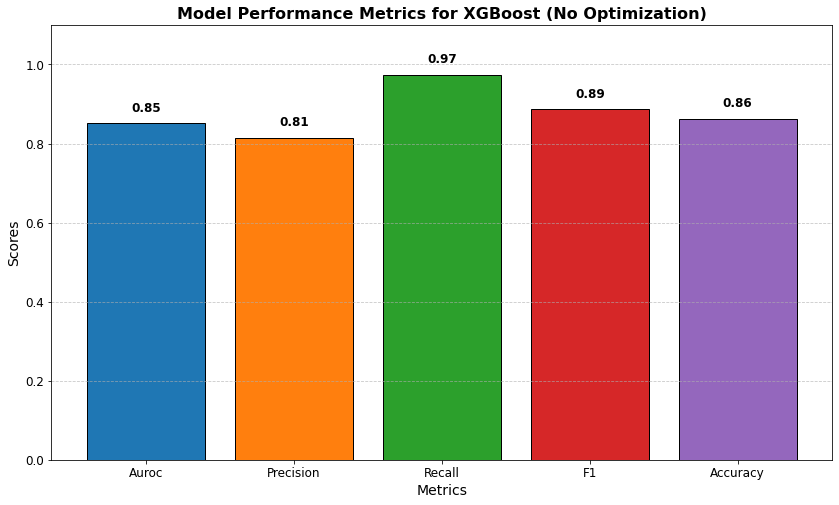

In [21]:
import matplotlib.pyplot as plt
# Select metrics from the DataFrame
metrics = ['Auroc', 'Precision', 'Recall', 'F1', 'Accuracy']
values = noopt_df.loc[0, metrics]

# Create a larger bar plot with a modern color palette
plt.figure(figsize=(14, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Different colors for better contrast
bars = plt.bar(metrics, values, color=colors, edgecolor='black')

# Add titles and labels with larger font sizes
plt.title('Model Performance Metrics for XGBoost (No Optimization)', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.ylim(0, 1.1)  # Add some space above 1 for better visibility of the labels

# Display the values on top of each bar with better formatting
for i, v in enumerate(values):
    plt.text(i, v + 0.03, f'{v:.2f}', ha='center', fontsize=12, fontweight='bold', color='black')

# Enhance visibility with grid lines and adjust y-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding dashed gridlines to the y-axis
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Show the plot
plt.show()

# Stage 2: XGBoost finding hyperparameters

In [22]:
xgb = XGBClassifier(    
        early_stopping_rounds=None, # Don't stop early, there is friction here between XGB API and SKL API
        # you would need eval_set=[(X_val, y_val)], but that does not work and depending on the implementation may 
        # contribute to an over-optimistic estimate of performance
        use_label_encoder= False,
        colsample_bylevel=1,
        colsample_bynode=1,
        max_bin=256,
        booster= 'gbtree',
        tree_method= 'gpu_hist',
        importance_type='gain',    
        objective='binary:logistic',
        eval_metric='logloss',
        predictor='gpu_predictor',         
        verbosity=0,
        silent=True)
    
p_grid = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.03, 0.3),
        "max_depth": randint(2, 8),        
        "subsample": uniform(0.6, 0.4)
}
    
search = RandomizedSearchCV(xgb, 
                            param_distributions=p_grid,
                            random_state=None, 
                            n_iter=200, 
                            cv=KFold(n_splits=5, shuffle=False),
                            verbose=False)
    
search.fit(X_train, y_train)
search.best_params_

{'colsample_bytree': 0.8721377457872924,
 'gamma': 0.08380088568695981,
 'learning_rate': 0.0408508641293628,
 'max_depth': 7,
 'subsample': 0.6431254905747706}

In [23]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Predicting using the optimized search model
xgb_search_preds = search.predict(X_test)

# Calculating the accuracy
search_accuracy = round(accuracy_score(y_true=y_test, y_pred=xgb_search_preds), 4)

# Creating the DataFrame with the accuracy metric added
search_df = pd.DataFrame(data=[[
    'unsw-nb15-binary',
    'xgb-search',
    X_train.shape,
    X_val.shape,
    X_test.shape,
    round(roc_auc_score(y_true=y_test, y_score=xgb_search_preds), 4),
    round(precision_score(y_true=y_test, y_pred=xgb_search_preds), 4),
    round(recall_score(y_true=y_test, y_pred=xgb_search_preds), 4),
    round(f1_score(y_true=y_test, y_pred=xgb_search_preds), 4),
    search_accuracy  # Adding accuracy to the DataFrame
]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1', 'Accuracy'])

search_df

,AtkCls,model,TrainShape,ValShape,TestShape,Auroc,Precision,Recall,F1,Accuracy
0,unsw-nb15-binary,xgb-search,"(149040, 34)","(26301, 34)","(82332, 34)",0.8057,0.7614,0.9924,0.8617,0.8246


<Figure size 1008x576 with 0 Axes>

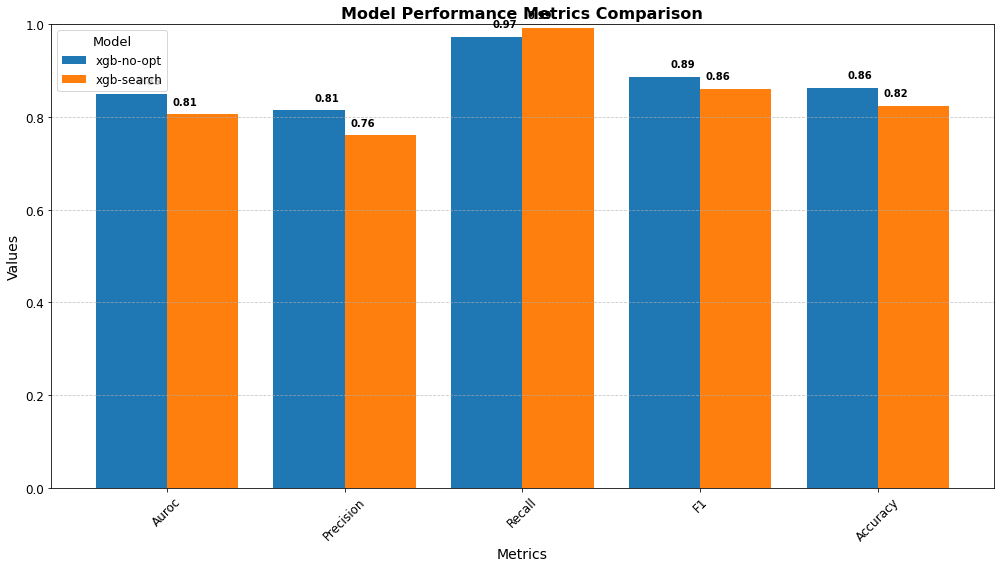

In [24]:
import matplotlib.pyplot as plt

# Combine the two DataFrames
combined_df = pd.concat([noopt_df, search_df], ignore_index=True)

# Set the index to the model names for easier plotting
combined_df.set_index('model', inplace=True)

# Select only the metric columns for plotting
metrics = ['Auroc', 'Precision', 'Recall', 'F1', 'Accuracy']

# Plotting
plt.figure(figsize=(14, 8))  # Increased figure size
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct colors for each metric

combined_df[metrics].T.plot(kind='bar', figsize=(14, 8), color=colors, width=0.8)  # Increased bar width

# Add titles and labels
plt.title('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')  # Larger title
plt.xlabel('Metrics', fontsize=14)  # Larger x-label
plt.ylabel('Values', fontsize=14)  # Larger y-label
plt.ylim(0, 1)  # Since all metrics are between 0 and 1

# Display the values on top of each bar
for i, (index, row) in enumerate(combined_df[metrics].iterrows()):
    for j, value in enumerate(row):
        plt.text(j + i * 0.2 - 0.1, value + 0.02, f"{value:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

plt.xticks(rotation=45, fontsize=12)  # Adjust x-tick labels
plt.yticks(fontsize=12)  # Adjust y-tick labels
plt.legend(title='Model', title_fontsize='13', fontsize='12')  # Legend formatting
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


# Stage 3: XGBoost final classification with optimized parameters.
Now we allow for more boosting rounds and enable early stopping on a validation set which has been kept separate and invisible in the previous stages. 

Curiously, there is no improvement whatsoever. The unoptimized version scores exactly the same.

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Define the XGBClassifier with early stopping
xgb_earlystop = XGBClassifier(
    n_estimators=1000,
    early_stopping_rounds=8,
    use_label_encoder=False,
    colsample_bylevel=1,
    colsample_bynode=1,
    max_bin=256,
    booster='gbtree',
    tree_method='hist',  # Changed to 'hist' to ensure compatibility with CPU
    importance_type='gain',
    objective='binary:logistic',
    eval_metric='logloss',
    predictor='auto',  # Changed to 'auto' for CPU compatibility
    verbosity=0,
    silent=True
)

# Train the model with early stopping using a validation set
xgb_earlystop.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predicting using the optimized early stopping model
xgb_early_preds = xgb_earlystop.predict(X_test)

# Calculating the accuracy for the optimized model
opt_accuracy = round(accuracy_score(y_true=y_test, y_pred=xgb_early_preds), 4)

# Creating the DataFrame with the accuracy metric added
opt_df = pd.DataFrame(data=[[
    'unsw-nb15-binary',
    'xgb-opt',
    X_train.shape,
    X_val.shape,
    X_test.shape,
    round(roc_auc_score(y_true=y_test, y_score=xgb_early_preds), 4),
    round(precision_score(y_true=y_test, y_pred=xgb_early_preds), 4),
    round(recall_score(y_true=y_test, y_pred=xgb_early_preds), 4),
    round(f1_score(y_true=y_test, y_pred=xgb_early_preds), 4),
    opt_accuracy  # Adding accuracy to the DataFrame
]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1', 'Accuracy'])

# Display the DataFrame
print(opt_df)


             AtkCls    model    TrainShape     ValShape    TestShape   Auroc  \
0  unsw-nb15-binary  xgb-opt  (149040, 34)  (26301, 34)  (82332, 34)  0.8387   

   Precision  Recall      F1  Accuracy  
0     0.7997  0.9774  0.8797    0.8528  


<Figure size 1008x576 with 0 Axes>

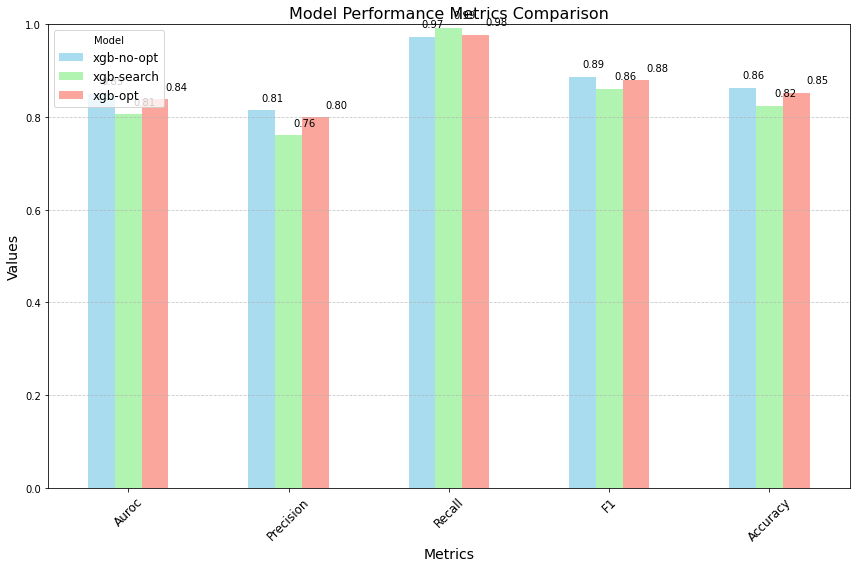

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine the three DataFrames
combined_df = pd.concat([noopt_df, search_df, opt_df], ignore_index=True)

# Set the index to the model names for easier plotting
combined_df.set_index('model', inplace=True)

# Select only the metric columns for plotting
metrics = ['Auroc', 'Precision', 'Recall', 'F1', 'Accuracy']

# Plotting
plt.figure(figsize=(14, 8))
combined_df[metrics].T.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'lightgreen', 'salmon', 'orange', 'violet'], alpha=0.7)

# Add titles and labels
plt.title('Model Performance Metrics Comparison', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.ylim(0, 1)  # Since all metrics are between 0 and 1

# Display the values on top of each bar
for i, (index, row) in enumerate(combined_df[metrics].iterrows()):
    for j, value in enumerate(row):
        plt.text(j + i * 0.2 - 0.1, value + 0.02, f"{value:.2f}", ha='center', fontsize=10, color='black')

# Adjust x-ticks
plt.xticks(rotation=45, fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Model', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


In [27]:
opt_df

,AtkCls,model,TrainShape,ValShape,TestShape,Auroc,Precision,Recall,F1,Accuracy
0,unsw-nb15-binary,xgb-opt,"(149040, 34)","(26301, 34)","(82332, 34)",0.8387,0.7997,0.9774,0.8797,0.8528


# Stage 4: What if we use the full training set?
If you do not split off a validation set for early stopping and just use the unoptimized XGB model with pretty standard hyperparameter choices then you get a slightly better result .9216 AUROC.

In [28]:
print(X_train.shape)
X_train = pd.concat(objs=[X_train, X_val], axis=0, copy=False)
y_train = pd.concat(objs=[y_train, y_val], axis=0, copy=False)
X_train.shape

(149040, 34)


(175341, 34)

In [29]:
 xgb = XGBClassifier(
        n_estimators= 100,
        use_label_encoder= False,
        max_depth= 8,
        booster= 'gbtree',
        tree_method= 'hist',
        subsample= 0.5,
        colsample_bytree= 0.5,
        importance_type= 'gain',
        objective='binary:logistic',
        eval_metric='logloss',
        predictor= 'cpu_predictor',
    )

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)  
        
no_val_df = pd.DataFrame(data=[[
        'unsw-nb15-binary',
        'xgb-no-opt',
        X_train.shape,
        X_val.shape,
        X_test.shape,
        round(roc_auc_score(y_true=y_test, y_score=xgb_preds),4),
        round(precision_score(y_true=y_test, y_pred=xgb_preds), 4),
        round(recall_score(y_true=y_test, y_pred=xgb_preds), 4),
        round(f1_score(y_true=y_test, y_pred=xgb_preds), 4)
    ]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1'])
no_val_df

,AtkCls,model,TrainShape,ValShape,TestShape,Auroc,Precision,Recall,F1
0,unsw-nb15-binary,xgb-no-opt,"(175341, 34)","(26301, 34)","(82332, 34)",0.8586,0.8247,0.9696,0.8913


In [30]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Fit the model
xgb.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb.predict(X_test)  

# Calculate accuracy
no_val_accuracy = round(accuracy_score(y_true=y_test, y_pred=xgb_preds), 4)

# Create DataFrame with all metrics including accuracy
no_val_df = pd.DataFrame(data=[[
    'unsw-nb15-binary',
    'xgb-no-opt',
    X_train.shape,
    X_val.shape,
    X_test.shape,
    round(roc_auc_score(y_true=y_test, y_score=xgb_preds), 4),
    round(precision_score(y_true=y_test, y_pred=xgb_preds), 4),
    round(recall_score(y_true=y_test, y_pred=xgb_preds), 4),
    round(f1_score(y_true=y_test, y_pred=xgb_preds), 4),
    no_val_accuracy  # Adding accuracy to the DataFrame
]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1', 'Accuracy'])

no_val_df

,AtkCls,model,TrainShape,ValShape,TestShape,Auroc,Precision,Recall,F1,Accuracy
0,unsw-nb15-binary,xgb-no-opt,"(175341, 34)","(26301, 34)","(82332, 34)",0.8586,0.8247,0.9696,0.8913,0.8698


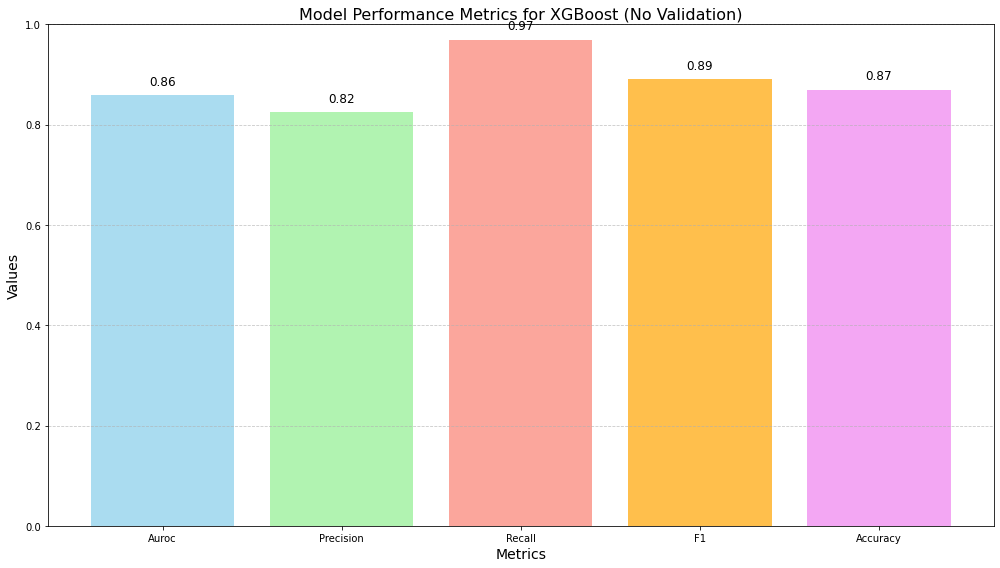

In [40]:
import matplotlib.pyplot as plt

# Select the metric columns for plotting
metrics = ['Auroc', 'Precision', 'Recall', 'F1', 'Accuracy']
values = no_val_df.loc[0, metrics]

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'orange', 'violet'], alpha=0.7)

# Add titles and labels
plt.title('Model Performance Metrics for XGBoost (No Validation)', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.ylim(0, 1)  # All metrics are between 0 and 1

# Display the values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, color='black')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


# Stage 5: XGBoost using better thresholds
This new stage (V3) came about because of the sequence of findings in [NSL-KDD-02-XGB-binary:0.971 AUROC](https://www.kaggle.com/dhoogla/nsl-kdd-02-xgb-binary-0-971-auroc)
There, the XGBoost model had a drastic reduction in AUROC compared to the much simpler Ensemble OneR model. That was unexpected, but after some digging the expected order between the classifiers was re-established.

The order was restored, primarily through the use of better thresholds for class attribution, which is what we're adding here as well.

Of course, when we pick a threshold for binary classification other than the default 0.5, without testing whether it is stable, we open ourselves to an over-optimistic prediction. 

optim threshold -> AUROC 0.9851 - F1 0.9368

0.5 threshold -> AUROC 0.9211 - F1 0.9225

In [33]:
xgb_proba_preds = xgb_noopt.predict_proba(X_test)
xgb_proba_preds.shape

(82332, 2)

In [34]:
xgb_proba_preds = xgb_proba_preds[:,1]

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba_preds)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best threshold", best_thresh)

Best threshold 0.93264705


In [36]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `xgb_proba_preds` contains predicted probabilities and `best_thresh` is the chosen threshold
# Calculate predictions based on the threshold
xgb_proba_preds = xgb.predict_proba(X_test)[:, 1]  # Assuming probabilities for the positive class
predicted_labels = np.where(xgb_proba_preds > best_thresh, 1, 0)

# Calculate accuracy
proba_thresh_accuracy = round(accuracy_score(y_true=y_test, y_pred=predicted_labels), 4)

# Create DataFrame with all metrics including accuracy
proba_thresh_df = pd.DataFrame(data=[[
    'unsw-nb15-binary',
    'xgb-no-opt-proba-thresh',
    X_train.shape,
    X_val.shape,
    X_test.shape,
    round(roc_auc_score(y_true=y_test, y_score=xgb_proba_preds), 4),
    round(precision_score(y_true=y_test, y_pred=predicted_labels), 4),
    round(recall_score(y_true=y_test, y_pred=predicted_labels), 4),
    round(f1_score(y_true=y_test, y_pred=predicted_labels), 4),
    proba_thresh_accuracy  # Adding accuracy to the DataFrame
]], columns=['AtkCls', 'model', 'TrainShape', 'ValShape', 'TestShape', 'Auroc', 'Precision', 'Recall', 'F1', 'Accuracy'])

proba_thresh_df


,AtkCls,model,TrainShape,ValShape,TestShape,Auroc,Precision,Recall,F1,Accuracy
0,unsw-nb15-binary,xgb-no-opt-proba-thresh,"(175341, 34)","(26301, 34)","(82332, 34)",0.9783,0.9766,0.87,0.9202,0.9169


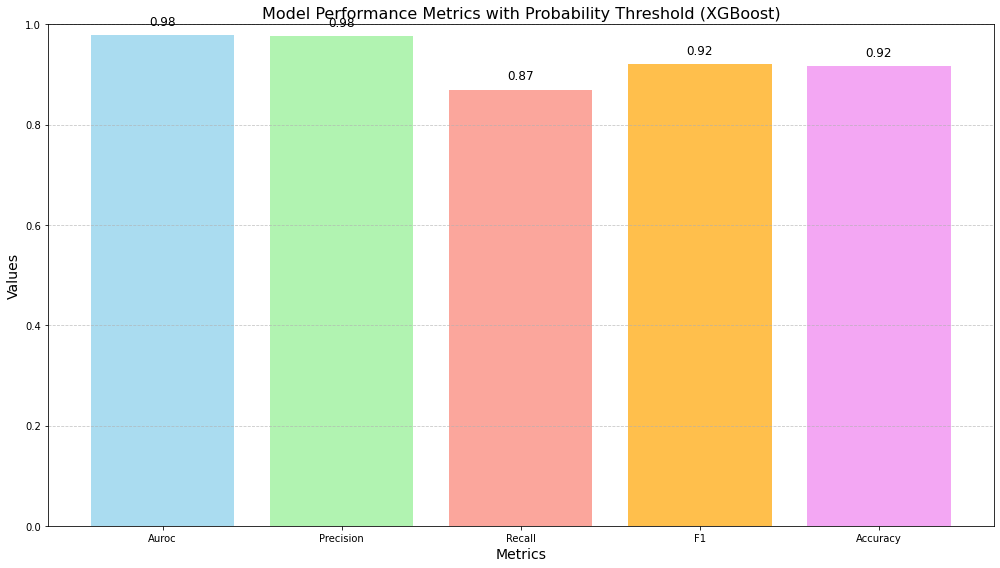

In [41]:
import matplotlib.pyplot as plt

# Select the metric columns for plotting
metrics = ['Auroc', 'Precision', 'Recall', 'F1', 'Accuracy']
values = proba_thresh_df.loc[0, metrics]

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'orange', 'violet'], alpha=0.7)

# Add titles and labels
plt.title('Model Performance Metrics with Probability Threshold (XGBoost)', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.ylim(0, 1)  # All metrics are between 0 and 1

# Display the values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, color='black')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()
